## First, we import lots of things

In [1]:
# !pip install image
from PIL import Image
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.cross_validation import train_test_split
from sklearn.random_projection import GaussianRandomProjection
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from rep.metaml import FoldingRegressor
from rep.estimators import XGBoostRegressor, TheanetsRegressor

## Download the picture

I took quite complex picture with many little details

In [5]:
!wget http://static.boredpanda.com/blog/wp-content/uploads/2014/08/cat-looking-at-you-black-and-white-photography-1.jpg  -O image.jpg
# !wget http://orig05.deviantart.net/1d93/f/2009/084/5/2/new_york_black_and_white_by_morgadu.jpg -O image.jpg

--2016-02-16 15:40:20--  http://static.boredpanda.com/blog/wp-content/uploads/2014/08/cat-looking-at-you-black-and-white-photography-1.jpg
Resolving static.boredpanda.com... 94.31.29.99
Connecting to static.boredpanda.com|94.31.29.99|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80728 (79K) [image/jpeg]
Saving to: 'image.jpg'

image.jpg           100%[=====================>]  78.84K  --.-KB/s   in 0.05s  

2016-02-16 15:40:20 (1.41 MB/s) - 'image.jpg' saved [80728/80728]



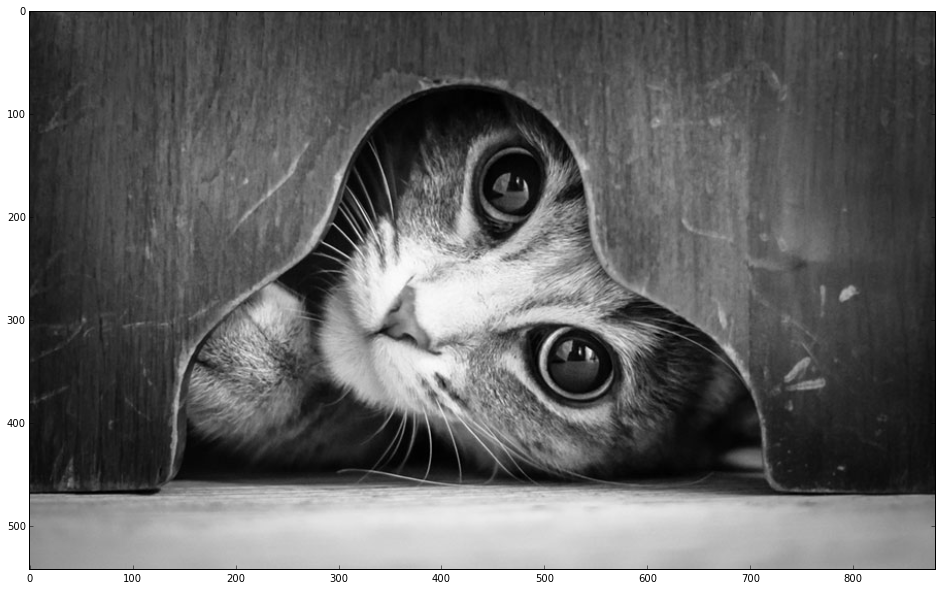

In [6]:
image = numpy.asarray(Image.open('./image.jpg')).mean(axis=2)

plt.figure(figsize=[20, 10])
plt.imshow(image, cmap='gray')

## Define a function to train regressor

`train_size` is how many pixels shall be used in reconstructing the picture. By default, the algorithm will use only 2% of pixels

In [7]:
def train_display(regressor, image, train_size=0.02):
    height, width = image.shape
    flat_image = image.reshape(-1)
    xs = numpy.arange(len(flat_image)) % width
    ys = numpy.arange(len(flat_image)) // width    
    data = numpy.array([xs, ys]).T
    target = flat_image
    trainX, testX, trainY, testY = train_test_split(data, target, train_size=train_size, random_state=42)
    mean = trainY.mean()
    regressor.fit(trainX, trainY - mean)
    new_flat_picture = regressor.predict(data) + mean
    plt.figure(figsize=[20, 10])
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.subplot(122)
    plt.imshow(new_flat_picture.reshape(height, width), cmap='gray')

## Linear regression
not very surprising result

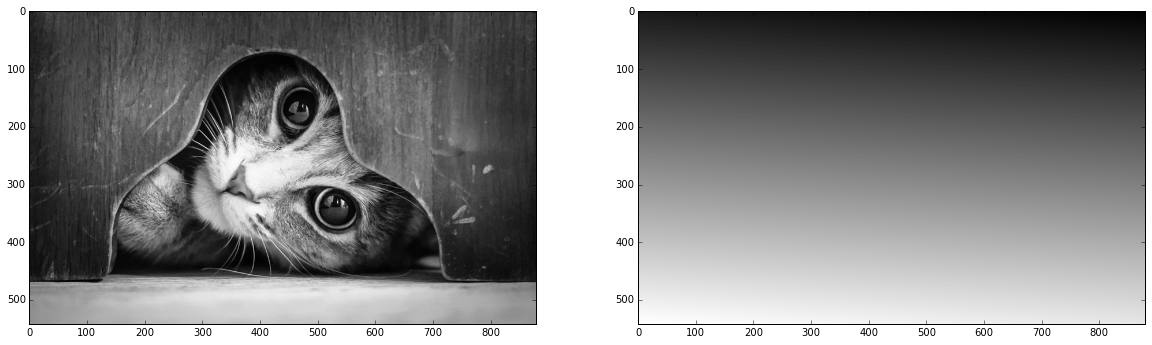

In [8]:
train_display(LinearRegression(), image)

## Decision tree limited by depth

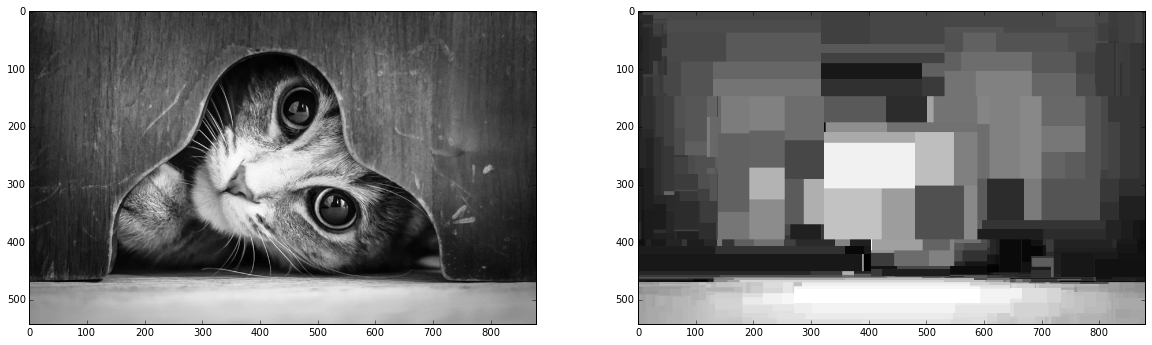

In [9]:
train_display(DecisionTreeRegressor(max_depth=10), image)

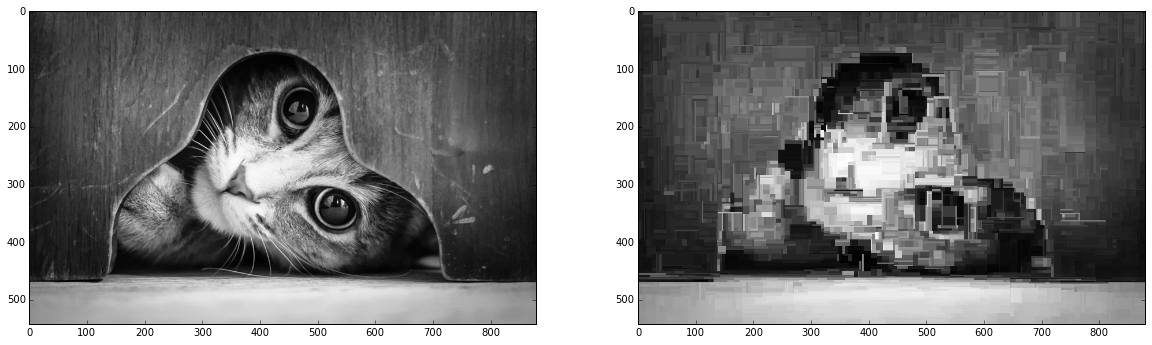

In [10]:
train_display(DecisionTreeRegressor(max_depth=20), image)

## Decision tree limited by minimal number of samples in a leaf

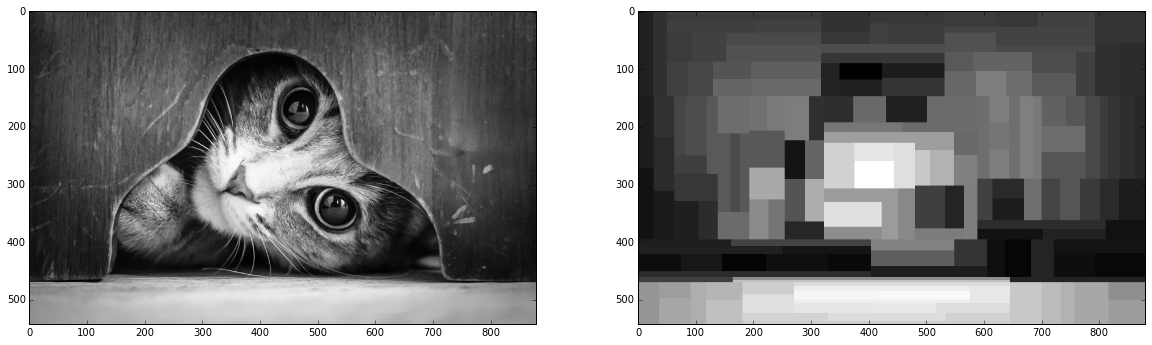

In [11]:
train_display(DecisionTreeRegressor(min_samples_leaf=40), image)

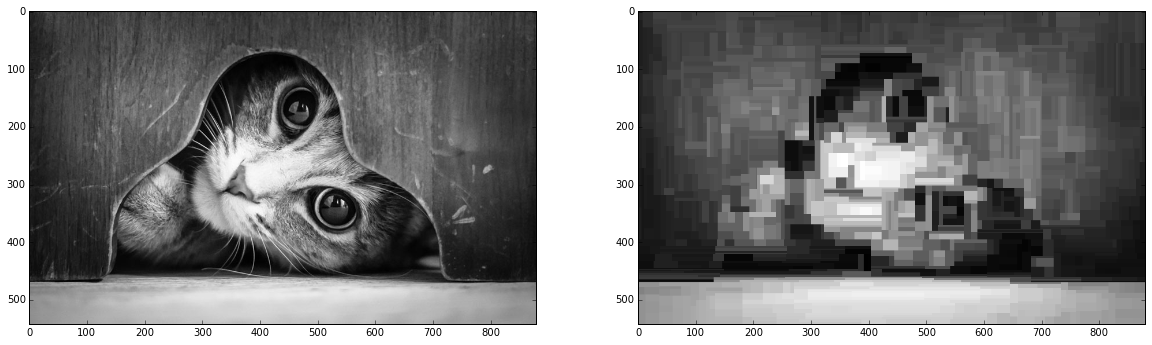

In [12]:
train_display(DecisionTreeRegressor(min_samples_leaf=5), image)

## RandomForest

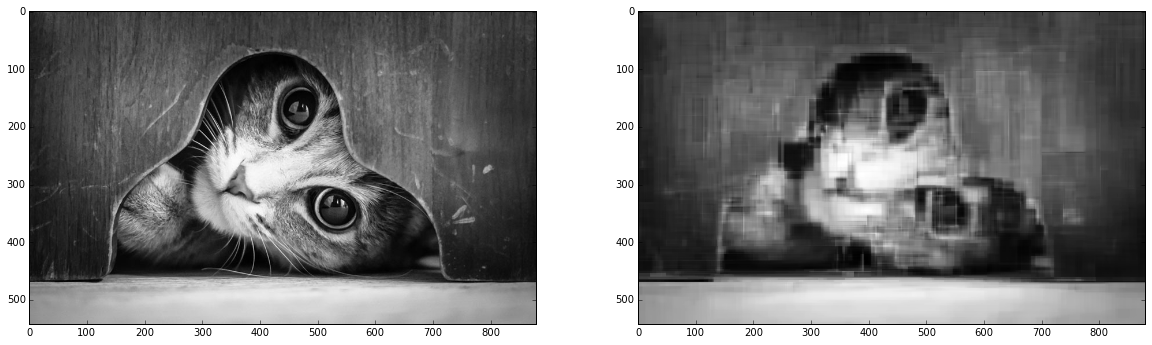

In [13]:
train_display(RandomForestRegressor(n_estimators=100), image)

## K Nearest Neighbours

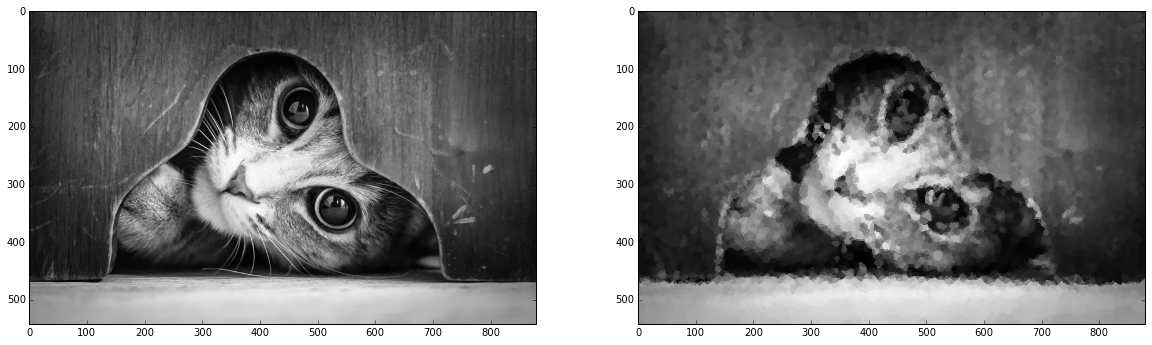

In [14]:
train_display(KNeighborsRegressor(n_neighbors=2), image)

### more neighbours + weighting according to distance
to make predictions smoother

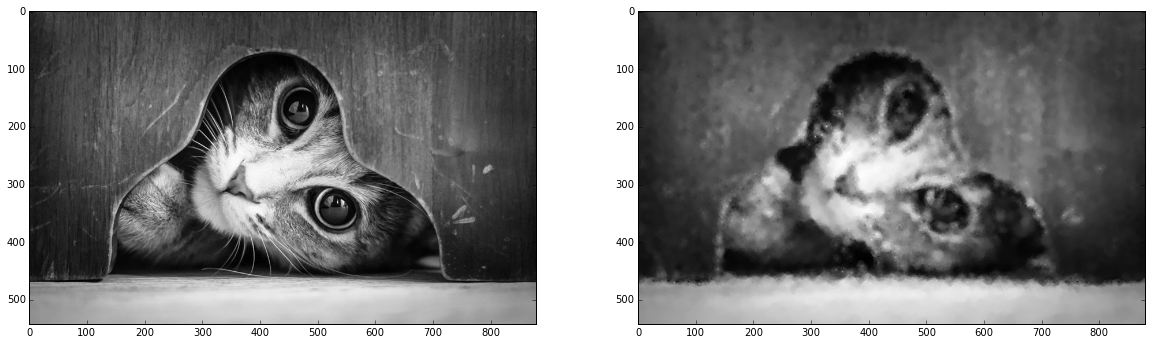

In [15]:
train_display(KNeighborsRegressor(n_neighbors=5, weights='distance'), image)

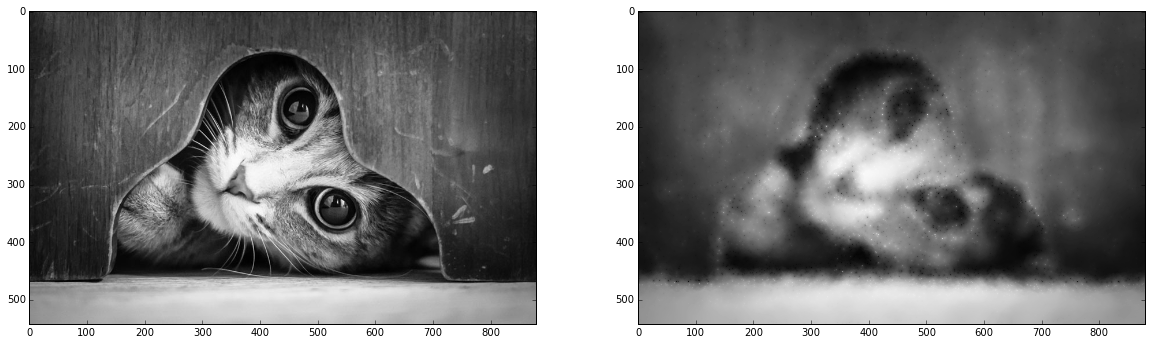

In [16]:
train_display(KNeighborsRegressor(n_neighbors=25, weights='distance'), image)

## KNN with canberra metric

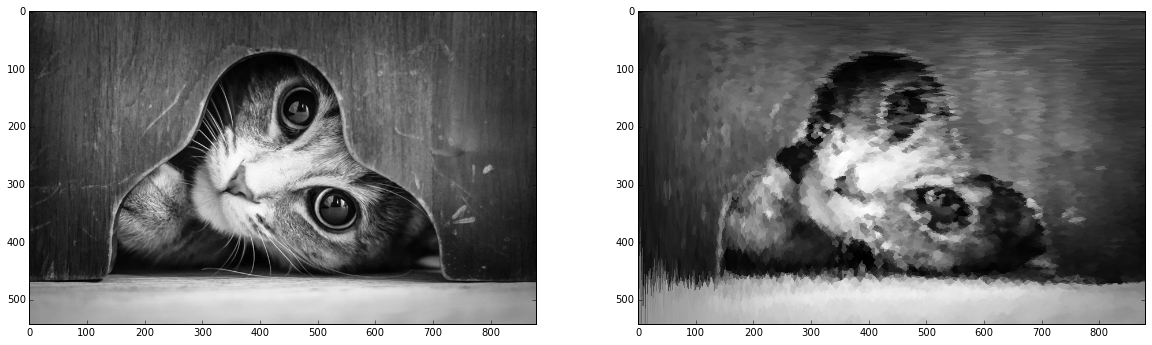

In [17]:
train_display(KNeighborsRegressor(n_neighbors=2, metric='canberra'), image)

## Gradient Boosting

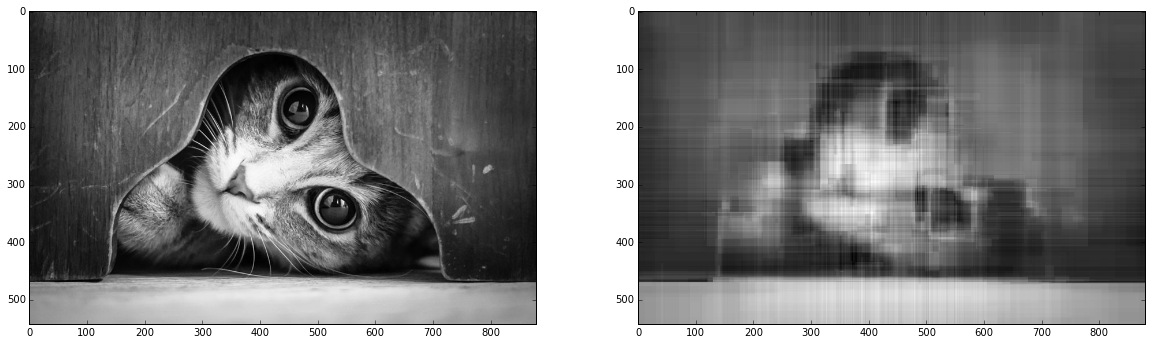

In [18]:
train_display(XGBoostRegressor(max_depth=5, n_estimators=100, subsample=0.5, nthreads=4), image)

## Gradient Boosting with deep trees

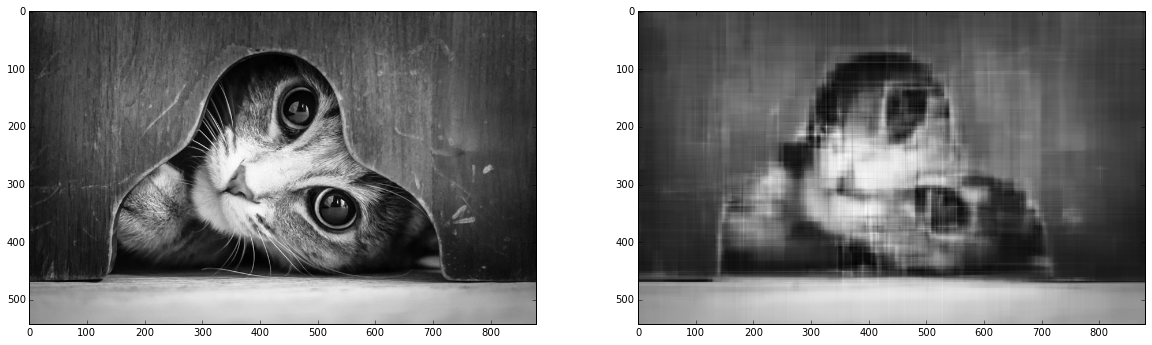

In [19]:
train_display(XGBoostRegressor(max_depth=12, n_estimators=100, subsample=0.5, nthreads=4, eta=0.1), image)

## Neural networks

neural networks provide smooth predictions and are not able to deal with tiny sharp details of pictures.

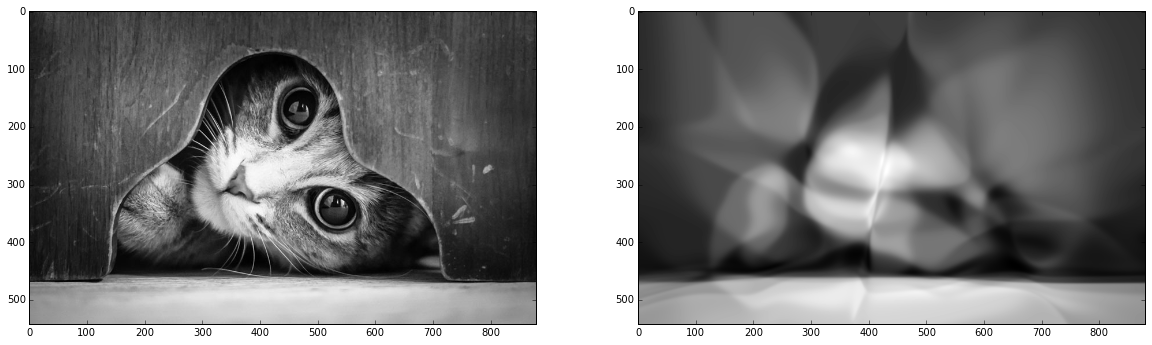

In [20]:
train_display(TheanetsRegressor(layers=[20, 20], hidden_activation='tanh', 
                                trainers=[{'algo': 'adadelta', 'learning_rate': 0.01}]), image)

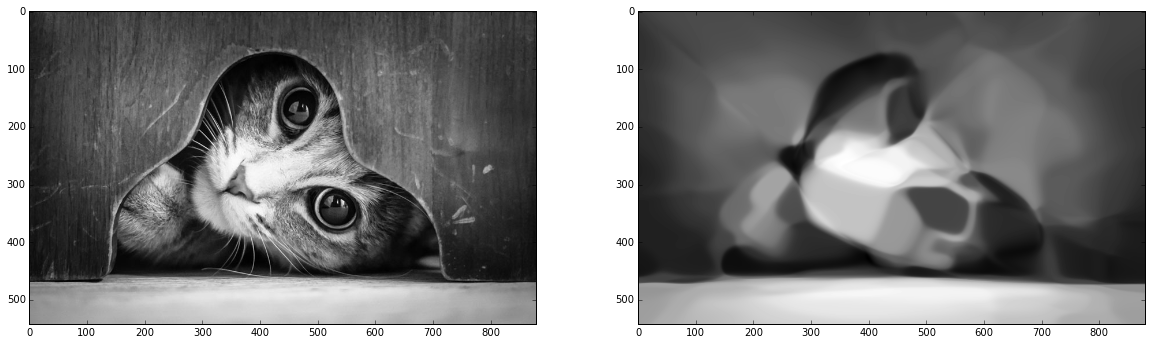

In [21]:
train_display(TheanetsRegressor(layers=[40, 40, 40, 40], hidden_activation='tanh', 
                                trainers=[{'algo': 'adadelta', 'learning_rate': 0.01}]), image)

## AdaBoost over Decision Trees using random projections

/Users/axelr/.conda/envs/rep/lib/python2.7/site-packages/sklearn/random_projection.py:375: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 10).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


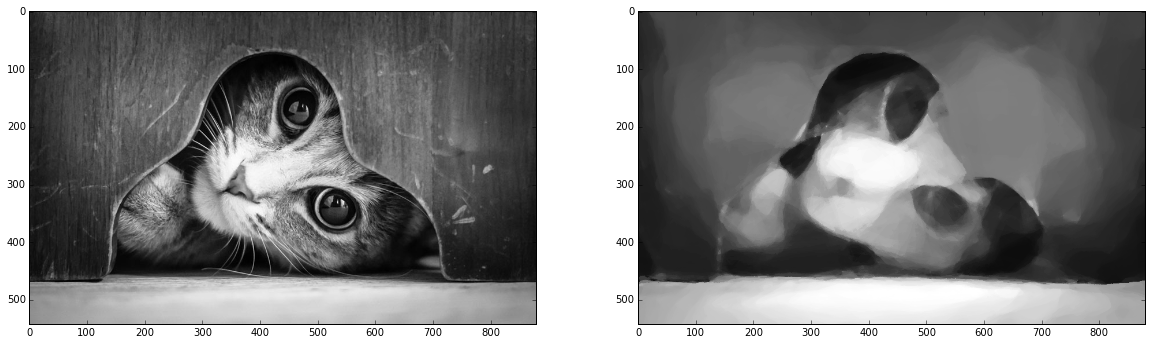

In [22]:
base = make_pipeline(GaussianRandomProjection(n_components=10), 
                     DecisionTreeRegressor(max_depth=10, max_features=5))
train_display(AdaBoostRegressor(base, n_estimators=50, learning_rate=0.05), image)

## Bagging over decision trees using random projections

This is sometimes referred as Random Forest too (since this idea was proposed by Leo Breiman in the same paper).

/Users/axelr/.conda/envs/rep/lib/python2.7/site-packages/sklearn/random_projection.py:375: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 15).The dimensionality of the problem will not be reduced.
  DataDimensionalityWarning)


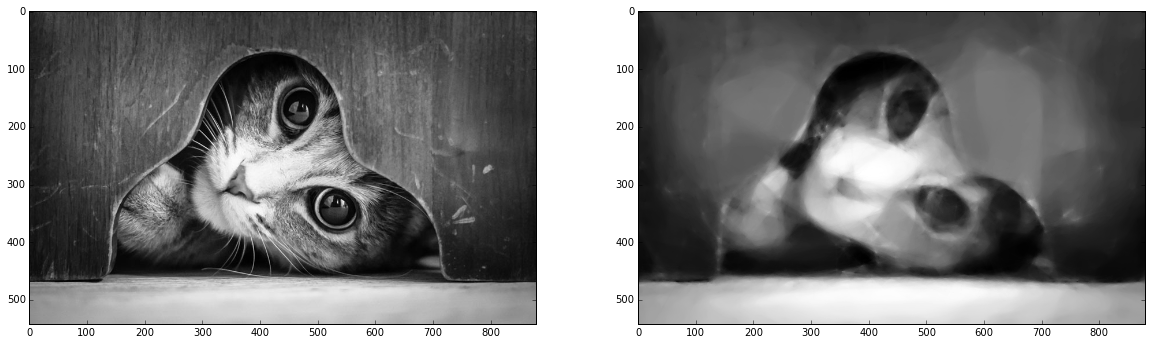

In [23]:
base = make_pipeline(GaussianRandomProjection(n_components=15), 
                     DecisionTreeRegressor(max_depth=12, max_features=5))
train_display(BaggingRegressor(base, n_estimators=100), image)

## See also:

- [Drawing an image with deep neural network](http://cs.stanford.edu/people/karpathy/convnetjs/demo/image_regression.html) Andrej Karpathy
- [Artificial artist](http://betatim.github.io/posts/artificial-artist/) by Tim Head
- [Painting photo in different artistic styles](http://arxiv.org/pdf/1508.06576v1.pdf). Note that the study in this paper is quite different from things demonstrated in the post. 

Feel free to download the notebook from repository and play with other images / parameters.